# Geometric Low-Rank Tensor Completion

**Published**: September 27, 2019

**Author**: Xinyu Chen [[**GitHub homepage**](https://github.com/xinychen)]

**Download**: This Jupyter notebook is at our GitHub repository. If you want to evaluate the code, please download the notebook from the repository of [**tensor-learning**](https://github.com/xinychen/tensor-learning/blob/master/content/GLTC.ipynb).

----------------

Geometric Low-rank Tensor Completion (GLTC) is an approach of reconstructing missing values within tensors. In particular, this approach could use the graphs as side information in form of regularizer.


## Motivation: Real-World Applications

In the field of computer vision, tensor completion problem arises as as many pixels may be missing in color images.

### Graph in image

The nearby pixels are very similiar. Take the image of Lena as an example:

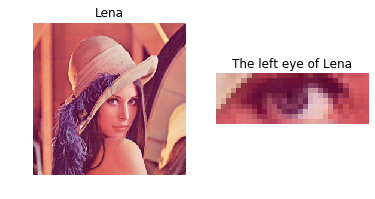

In [2]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

lena = imageio.imread('../datasets/color-images/lena.bmp')

dim1, dim2, dim3 = lena.shape
a = int(dim1/2)
b = int(dim1/2) + 10
c = int(dim2/2) - 10
d = int(dim2/2) + 20

plt.subplot(1, 2, 1)
plt.imshow(lena)
plt.title('Lena')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lena[a:b, c:d, :])
plt.title('The left eye of Lena')
plt.axis('off')

plt.show()

> Figure 1: Lena and her left eye. The pixels of the left eye is apparent.

## Selected Images

We will carry out our image inpainting experiments on the following images.

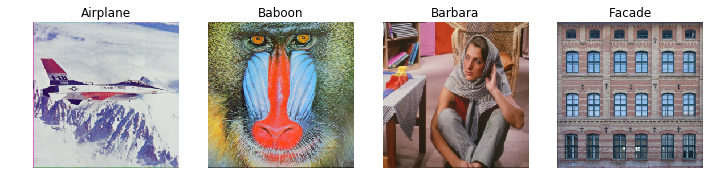

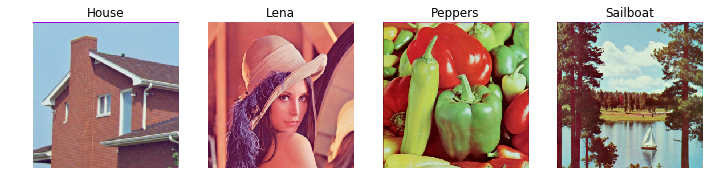

In [3]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

plt.subplots(1, 4, figsize = (12, 20))
plt.subplot(1, 4, 1)
plt.imshow(imageio.imread('../datasets/color-images/airplane.bmp'))
plt.title('Airplane')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(imageio.imread('../datasets/color-images/baboon.bmp'))
plt.title('Baboon')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(imageio.imread('../datasets/color-images/barbara.bmp'))
plt.title('Barbara')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(imageio.imread('../datasets/color-images/facade.bmp'))
plt.title('Facade')
plt.axis('off')

plt.subplots(1, 4, figsize = (12, 20))
plt.subplot(1, 4, 1)
plt.imshow(imageio.imread('../datasets/color-images/house.bmp'))
plt.title('House')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(imageio.imread('../datasets/color-images/lena.bmp'))
plt.title('Lena')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(imageio.imread('../datasets/color-images/peppers.bmp'))
plt.title('Peppers')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(imageio.imread('../datasets/color-images/sailboat.bmp'))
plt.title('Sailboat')
plt.axis('off')

plt.show()

## Geometric Low-Rank Tensor Completion

We start by importing the necessary dependencies. We will make use of `numpy`.

In [4]:
import numpy as np
from numpy.linalg import inv as inv
import numpy.linalg as ng

In [5]:
def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

In [6]:
def mat2ten(mat, tensor_size, mode):
    index = list()
    index.append(mode)
    for i in range(tensor_size.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(tensor_size[index]), order = 'F'), 0, mode)

### Soft Thresholding Method

Reference:

Ryan Tibshirani, 2015. Lecture on Proximal Gradient Descent. [[**link**](http://www.stat.cmu.edu/~ryantibs/convexopt-S15/scribes/08-prox-grad-scribed.pdf)]

In [7]:
def soft_thresholding(mat, lambda0):
    u, s, v = np.linalg.svd(mat, full_matrices = 0)
    vec = s - lambda0
    pos = np.where(vec < 0)
    vec[pos] = 0
    
    return np.matmul(np.matmul(u, np.diag(vec)), v)

In [28]:
def GLTC(dense_tensor, sparse_tensor, beta, rho, maxiter):
    
    alpha = 1/3
    dim0 = sparse_tensor.ndim
    dim1, dim2, dim3 = sparse_tensor.shape
#     pos = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    position = np.where(sparse_tensor != 0)
    binary_tensor = np.zeros((dim1, dim2, dim3))
    binary_tensor[position] = 1
    tensor_hat = sparse_tensor.copy()
    
    X = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{X}} (n1*n2*3*d)
    Z = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{Z}} (n1*n2*3*d)
    T = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{T}} (n1*n2*3*d)
    for k in range(dim0):
        X[:, :, :, k] = tensor_hat
    
    D1 = np.zeros((dim1, dim1))
    for i in range(dim1 - 1):
        D1[i+1, i] = -1
        D1[i+1, i+1] = 1
    D2 = np.zeros((dim2, dim2))
    for i in range(dim2 - 1):
        D2[i+1, i] = -1
        D2[i+1, i+1] = 1
    
    for iters in range(maxiter):
        for k in range(dim0):
            Z[:, :, :, k] = mat2ten(soft_thresholding(ten2mat(X[:, :, :, k] + T[:, :, :, k]/rho, k), 
                                                      alpha/rho), np.array([dim1, dim2, dim3]), k)
            if k == 0:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D1.T, D1) + rho * np.eye(dim1)), 
                                         ten2mat(rho * Z[:, :, :, k] - T[:, :, :, k], k)), 
                               np.array([dim1, dim2, dim3]), k)
            elif k == 1:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D2.T, D2) + rho * np.eye(dim2)), 
                                         ten2mat(rho * Z[:, :, :, k] - T[:, :, :, k], k)), 
                               np.array([dim1, dim2, dim3]), k)
            else:
                var0 = Z[:, :, :, k] - T[:, :, :, k]/rho
            X[:, :, :, k] = (np.multiply(1 - binary_tensor, var0) 
                             + np.multiply(binary_tensor, sparse_tensor))
        tensor_hat = np.mean(X, axis = 3)
        for k in range(dim0):
            var = T[:, :, :, k] + rho * (X[:, :, :, k] - Z[:, :, :, k])
            T[:, :, :, k] = var.copy()
            X[:, :, :, k] = tensor_hat.copy()

#         rmse = np.sqrt(np.sum((dense_tensor[pos] - tensor_hat[pos]) ** 2)/dense_tensor[pos].shape[0])
#         if (iters + 1) % 100 == 0:
#             print('Iter: {}'.format(iters + 1))
#             print('RMSE: {:.6}'.format(rmse))
#             print()

#     if maxiter >= 100:
#         final_mape = np.sum(np.abs(dense_tensor[pos] - tensor_hat[pos])/dense_tensor[pos])/dense_tensor[pos].shape[0]
#         final_rmse = np.sqrt(np.sum((dense_tensor[pos] - tensor_hat[pos]) ** 2)/dense_tensor[pos].shape[0])
#         print('Imputation MAPE: {:.6}'.format(final_mape))
#         print('Imputation RMSE: {:.6}'.format(final_rmse))
#         print()
    return tensor_hat

## Experiments on Color Images

In the following, we will illustrate the performance of image inpainting tasks using Geometric Low-rank Tensor Completion (GLTC) model on some color images.

We set the missing scenario as

- missing at random (MAR), 
- row-wise missing at random (R-MAR),
- column-wise missing at random (C-MAR), 
- (row,column)-wise missing at random (RC-MAR),
- 50\% (row,column)-wise missing (RC-50),

and the missing rate as 30\%,50\%, and 70\%. In particular, we run the code for 20 times.

The recovery performance is measured by $$\text{RSE}=\frac{\|\mathcal{P}_{\Omega}^{\perp}(\mathcal{X})-\mathcal{P}_{\Omega}^{\perp}(\mathcal{Y})\|_{F}}{\|\mathcal{P}_{\Omega}^{\perp}(\mathcal{Y})\|_{F}}\times 100.$$

### Evaluated on `Lena` and `Peppers`

### Whole Performance

We choose the images of `house`, `lena`, `peppers`, and `sailboat` for evaluation.

#### MAR (Missing at random)

In [25]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

rho = 1
beta = 0.1 * rho
maxiter = 1000

im = ["house", "lena", "peppers", "sailboat"]
result = np.zeros((len(im), 3, 10))
for ima in range(len(im)):
    image = imageio.imread('../datasets/color-images/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask = np.round(np.random.rand(dim1, dim2) + 0.5 - rate)  # Generate a binary mask.
            sparse_image = image.copy()
            for k in range(dim3):
                sparse_image[:, :, k] = np.multiply(image[:, :, k], mask) # Generate incomplete image
            image_hat = GLTC(image, sparse_image, beta, rho, maxiter)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2)/np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse

In [26]:
print(np.mean(100 * ten2mat(result, 1), axis = 1))

[6.8212314  7.8005338  9.29822357]


#### R-MAR (Row-wise missing at random)

In [ ]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

rho = 1
beta = 0.1 * rho
maxiter = 1000

im = ["house", "lena", "peppers", "sailboat"]
result = np.zeros((len(im), 3, 10))
for ima in range(len(im)):
    image = imageio.imread('../datasets/color-images/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask_row = np.round(np.random.rand(dim1) + 0.5 - rate)
            image0 = image.copy()
            for i in range(dim2):
                for j in range(dim3):
                    image0[:, i, j] = np.multiply(image[:, i, j], mask_row)
            sparse_image = image0.copy() # Generate incomplete image
            image_hat = GLTC(image, sparse_image, beta, rho, maxiter)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2)/np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse

In [ ]:
print(np.mean(100 * result, axis = 1))

#### C-MAR (Column-wise missing at random)

In [ ]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

rho = 1
beta = 0.1 * rho
maxiter = 1000

im = ["house", "lena", "peppers", "sailboat"]
result = np.zeros((len(im), 3, 10))
for ima in range(len(im)):
    image = imageio.imread('../datasets/color-images/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask_column = np.round(np.random.rand(dim2) + 0.5 - rate)
            image0 = image.copy()
            for i in range(dim1):
                for j in range(dim3):
                    image0[i, :, j] = np.multiply(image[i, :, j], mask_column)
            sparse_image = image0.copy() # Generate incomplete image
            image_hat = GLTC(image, sparse_image, beta, rho, maxiter)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2)/np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse

In [ ]:
print(np.mean(100 * result, axis = 1))

#### RC-MAR

In [11]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

image = imageio.imread('../datasets/color-images/lena.bmp')

dim1, dim2, dim3 = image.shape
rho = 1
beta = 0.1 * rho
maxiter = 1000
result = np.zeros((3, 20))
for missing in range(result.shape[0]):
    for it in range(result.shape[1]):
        rate = 0.1 * (2 * missing + 3) # Set missing rate
        mask_row = np.round(np.random.rand(dim1) + 0.5 - (1 - np.sqrt(1 - rate)))
        mask_column = np.round(np.random.rand(dim2) + 0.5 - (1 - np.sqrt(1 - rate)))
        image0 = image.copy()
        for i in range(dim2):
            for j in range(dim3):
                image0[:, i, j] = np.multiply(image[:, i, j], mask_row)
        sparse_image = image0.copy() # Generate incomplete image
        for i in range(dim1):
            for j in range(dim3):
                sparse_image[i, :, j] = np.multiply(image0[i, :, j], mask_column)
        image_hat = GLTC(image, sparse_image, beta, rho, maxiter)
        image_rec = np.round(image_hat).astype(int)
        image_rec[np.where(image_rec > 255)] = 255
        image_rec[np.where(image_rec < 0)] = 0
        pos = np.where((image != 0) & (sparse_image == 0))
        rse = np.linalg.norm(image_rec[pos] - image[pos], 2)/np.linalg.norm(image[pos], 2)
        result[missing, it] = rse

In [12]:
print(np.mean(100 * result, axis = 1))
print(np.std(100 * result, axis = 1))

[7.58477431 7.98822927 9.61351901]
[0.3886684  0.26393558 0.36399833]


Table 1-1: **Experiment results** (RSE performance) of image inpainting for four images using GLTC:

| Scenarios |      MAR      |     R-MAR      |   C-MAR   |     RC-MAR     |
|:----------|--------------:|---------------:|----------:|---------------:|
| **30\%**  |     6.82      |  7.10$\pm$0.40 | -      |  8.60$\pm$0.43 |
| **50\%**  |     7.80      |  8.70$\pm$0.79 | -      | 10.72$\pm$0.74 |
| **70\%**  |     9.30      | 15.22$\pm$4.07 | -      | 20.87$\pm$3.04 |

The shape of the image is (256, 256, 3).


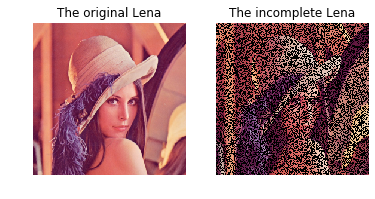

In [24]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

lena = imageio.imread('../datasets/color-images/lena.bmp')
print('The shape of the image is {}.'.format(lena.shape))

dim1, dim2, dim3 = lena.shape
lena_in = lena.copy()
rate = 0.5
mask = np.round(np.random.rand(dim1, dim2) + 0.5 - rate)  # Generate a binary mask.
for i in range(dim3):
    lena_in[:, :, i] = np.multiply(lena[:, :, i], mask)

plt.subplot(1, 2, 1)
plt.imshow(lena)
plt.title('The original Lena')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lena_in)
plt.title('The incomplete Lena')
plt.axis("off")

plt.show()

In [25]:
dense_tensor = lena
sparse_tensor = lena_in

In [27]:
import time
start = time.time()
alpha = np.ones(3)/3
rho = 1
alpha = 0.1*rho
maxiter = 1000
tensor_hat1 = GLTC(dense_tensor, sparse_tensor, alpha, rho, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 100
RMSE: 10.8645

Iter: 200
RMSE: 9.97959

Iter: 300
RMSE: 9.9684

Iter: 400
RMSE: 9.96798

Iter: 500
RMSE: 9.96797

Iter: 600
RMSE: 9.96797

Iter: 700
RMSE: 9.96797

Iter: 800
RMSE: 9.96797

Iter: 900
RMSE: 9.96797

Iter: 1000
RMSE: 9.96797

Imputation MAPE: 0.072164
Imputation RMSE: 9.96797

Running time: 117 seconds


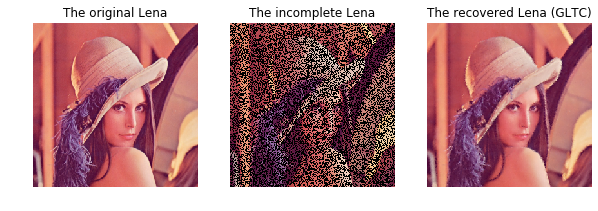

In [28]:
plt.subplots(1, 3, figsize=(10,25))

plt.subplot(1, 3, 1)
plt.imshow(lena)
plt.title('The original Lena')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(lena_in)
plt.title('The incomplete Lena')
plt.axis("off")

plt.subplot(1, 3, 3)
lena_rec = np.round(tensor_hat1).astype(int)
lena_rec[np.where(lena_rec > 255)] = 255
lena_rec[np.where(lena_rec < 0)] = 0
plt.imshow(lena_rec)
plt.title('The recovered Lena (GLTC)')
plt.axis('off')
plt.show()

In [40]:
# import time
# start = time.time()
# alpha = np.ones(3)/3
# rho = 0.001
# alpha = 0*rho
# maxiter = 1000
# tensor_hat2 = GLTC(dense_tensor, sparse_tensor, alpha, rho, maxiter)
# end = time.time()
# print('Running time: %d seconds'%(end - start))

Iter: 100
RMSE: 14.7013

Iter: 200
RMSE: 14.705

Iter: 300
RMSE: 14.7053

Iter: 400
RMSE: 14.7053

Iter: 500
RMSE: 14.7053

Iter: 600
RMSE: 14.7053

Iter: 700
RMSE: 14.7053

Iter: 800
RMSE: 14.7053

Iter: 900
RMSE: 14.7053

Iter: 1000
RMSE: 14.7053

Imputation MAPE: 0.116344
Imputation RMSE: 14.7053

Running time: 118 seconds


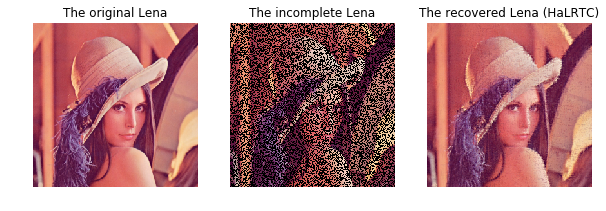

In [41]:
# plt.subplots(1, 3, figsize=(10,25))

# plt.subplot(1, 3, 1)
# plt.imshow(lena)
# plt.title('The original Lena')
# plt.axis('off')

# plt.subplot(1, 3, 2)
# plt.imshow(lena_in)
# plt.title('The incomplete Lena')
# plt.axis("off")

# lena_rec = np.round(tensor_hat2).astype(int)
# lena_rec[np.where(lena_rec > 255)] = 255
# lena_rec[np.where(lena_rec < 0)] = 0
# plt.subplot(1, 3, 3)
# plt.imshow(lena_rec)
# plt.title('The recovered Lena (HaLRTC)')
# plt.axis('off')
# plt.show()

### Missing value scenario: completely random at the row direction

The shape of the image is (256, 256, 3).


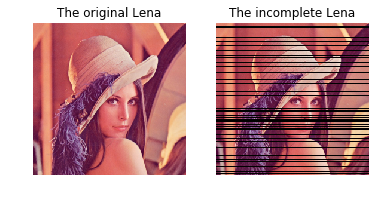

In [47]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

lena = imageio.imread('../datasets/color-images/lena.bmp')
print('The shape of the image is {}.'.format(lena.shape))

dim1, dim2, dim3 = lena.shape
lena_in = lena.copy()
rate = 0.3
mask = np.round(np.random.rand(dim1) + 0.5 - rate)  # Generate a binary mask.
for i in range(dim2):
    for j in range(dim3):
        lena_in[:, i, j] = np.multiply(lena[:, i, j], mask)

plt.subplot(1, 2, 1)
plt.imshow(lena)
plt.title('The original Lena')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lena_in)
plt.title('The incomplete Lena')
plt.axis("off")

plt.show()

The shape of the image is (256, 256, 3).


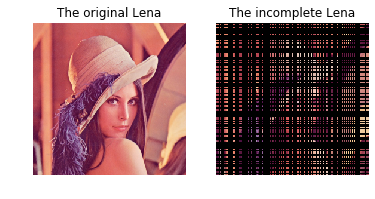

In [64]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

lena = imageio.imread('../datasets/color-images/lena.bmp')
print('The shape of the image is {}.'.format(lena.shape))

dim1, dim2, dim3 = lena.shape
lena0 = lena.copy()
rate = 0.5
mask_row = np.round(np.random.rand(dim1) + 0.5 - rate)
mask_column = np.round(np.random.rand(dim2) + 0.5 - rate)
for i in range(dim2):
    for j in range(dim3):
        lena0[:, i, j] = np.multiply(lena[:, i, j], mask_row)
lena_in = lena0.copy()
for i in range(dim1):
    for j in range(dim3):
        lena_in[i, :, j] = np.multiply(lena0[i, :, j], mask_column)

plt.subplot(1, 2, 1)
plt.imshow(lena)
plt.title('The original Lena')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lena_in)
plt.title('The incomplete Lena')
plt.axis("off")

plt.show()

In [65]:
dense_tensor = lena
sparse_tensor = lena_in

In [70]:
import time
start = time.time()
rho = 1
alpha = 0.1*rho
maxiter = 1000
tensor_hat1 = GLTC(dense_tensor, sparse_tensor, alpha, rho, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 100
RMSE: 63.7569

Iter: 200
RMSE: 41.351

Iter: 300
RMSE: 30.5122

Iter: 400
RMSE: 24.5125

Iter: 500
RMSE: 20.9771

Iter: 600
RMSE: 18.825

Iter: 700
RMSE: 17.4882

Iter: 800
RMSE: 16.6438

Iter: 900
RMSE: 16.1015

Iter: 1000
RMSE: 15.747

Imputation MAPE: 0.117197
Imputation RMSE: 15.747

Running time: 121 seconds


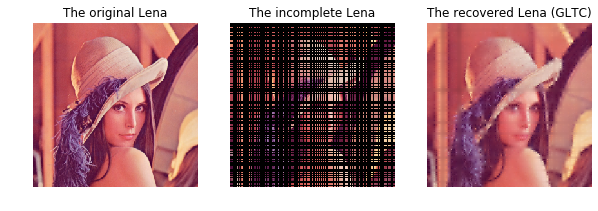

In [71]:
plt.subplots(1, 3, figsize=(10,25))

plt.subplot(1, 3, 1)
plt.imshow(lena)
plt.title('The original Lena')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(lena_in)
plt.title('The incomplete Lena')
plt.axis("off")

plt.subplot(1, 3, 3)
lena_rec = np.round(tensor_hat1).astype(int)
lena_rec[np.where(lena_rec > 255)] = 255
lena_rec[np.where(lena_rec < 0)] = 0
plt.imshow(lena_rec)
plt.title('The recovered Lena (GLTC)')
plt.axis('off')

plt.show()

In [16]:
# import time
# start = time.time()
# alpha = np.ones(3)/3
# rho = 0.001
# alpha = 0*rho
# maxiter = 1000
# tensor_hat2 = GLTC(dense_tensor, sparse_tensor, alpha, rho, maxiter)
# end = time.time()
# print('Running time: %d seconds'%(end - start))

Iter: 100
RMSE: 139.853

Iter: 200
RMSE: 139.853

Iter: 300
RMSE: 139.853

Iter: 400
RMSE: 139.853

Iter: 500
RMSE: 139.853

Iter: 600
RMSE: 139.853

Iter: 700
RMSE: 139.853

Iter: 800
RMSE: 139.853

Iter: 900
RMSE: 139.853

Iter: 1000
RMSE: 139.853

Imputation MAPE: 1.0
Imputation RMSE: 139.853

Running time: 110 seconds


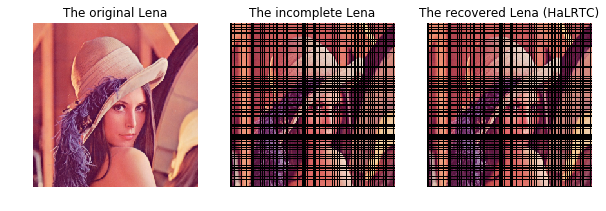

In [17]:
# plt.subplots(1, 3, figsize=(10,25))

# plt.subplot(1, 3, 1)
# plt.imshow(lena)
# plt.title('The original Lena')
# plt.axis('off')

# plt.subplot(1, 3, 2)
# plt.imshow(lena_in)
# plt.title('The incomplete Lena')
# plt.axis("off")

# lena_rec = np.round(tensor_hat2).astype(int)
# lena_rec[np.where(lena_rec > 255)] = 255
# lena_rec[np.where(lena_rec < 0)] = 0
# plt.subplot(1, 3, 3)
# plt.imshow(lena_rec)
# plt.title('The recovered Lena (HaLRTC)')
# plt.axis('off')
# plt.show()

## Improve the Image Resolution

Change image size from $\left(256,256,3\right)$ to $\left(512,512,3\right)$:

The shape of the image is (256, 256, 3).


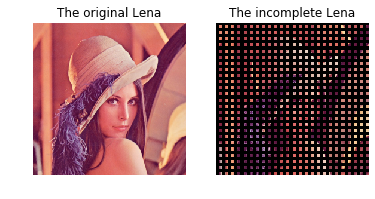

In [35]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

lena = imageio.imread('../datasets/color-images/lena.bmp')
print('The shape of the image is {}.'.format(lena.shape))

dim1, dim2, dim3 = lena.shape
lena_in = lena.copy()
for i in range(int(dim1/2)):
    lena_in[2*i, :, :] = 0
for j in range(int(dim2/2)):
    lena_in[:, 2*j, :] = 0

plt.subplot(1, 2, 1)
plt.imshow(lena)
plt.title('The original Lena')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lena_in)
plt.title('The incomplete Lena')
plt.axis("off")

plt.show()

In [36]:
dense_tensor = lena
sparse_tensor = lena_in

In [37]:
import time
start = time.time()
alpha = np.ones(3)/3
rho = 1
alpha = 0.1*rho
maxiter = 1000
tensor_hat1 = GLTC(dense_tensor, sparse_tensor, alpha, rho, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 100
RMSE: 13.6699

Iter: 200
RMSE: 10.5308

Iter: 300
RMSE: 10.5027

Iter: 400
RMSE: 10.5019

Iter: 500
RMSE: 10.5018

Iter: 600
RMSE: 10.5018

Iter: 700
RMSE: 10.5018

Iter: 800
RMSE: 10.5018

Iter: 900
RMSE: 10.5018

Iter: 1000
RMSE: 10.5018

Imputation MAPE: 0.0788268
Imputation RMSE: 10.5018

Running time: 120 seconds


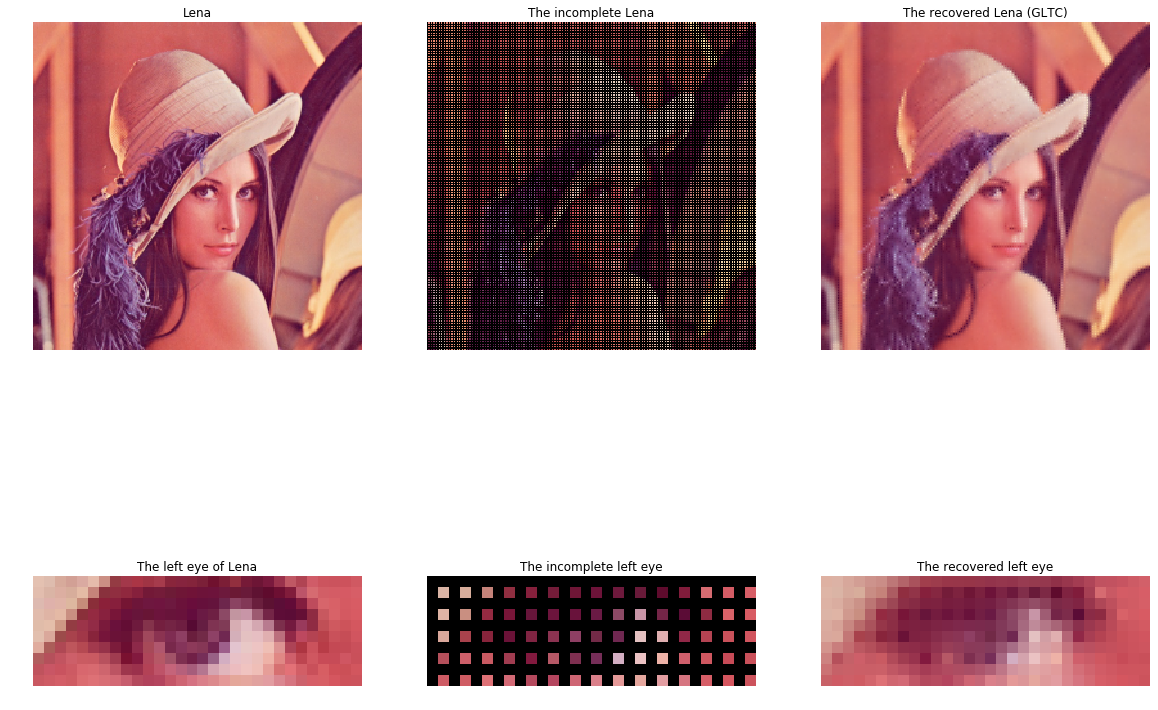

In [48]:
plt.subplots(2, 3, figsize=(20,15))

dim1, dim2, dim3 = lena.shape
a = int(dim1/2)
b = int(dim1/2) + 10
c = int(dim2/2) - 10
d = int(dim2/2) + 20

plt.subplot(2, 3, 1)
plt.imshow(lena)
plt.title('Lena')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(lena[a:b, c:d, :])
plt.title('The left eye of Lena')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(lena_in)
plt.title('The incomplete Lena')
plt.axis("off")

plt.subplot(2, 3, 5)
plt.imshow(lena_in[a:b, c:d, :])
plt.title('The incomplete left eye')
plt.axis("off")

plt.subplot(2, 3, 3)
lena_rec = np.round(tensor_hat1).astype(int)
lena_rec[np.where(lena_rec > 255)] = 255
lena_rec[np.where(lena_rec < 0)] = 0
plt.imshow(lena_rec)
plt.title('The recovered Lena (GLTC)')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(lena_rec[a:b, c:d, :])
plt.title('The recovered left eye')
plt.axis('off')

plt.show()

/Users/xinyuchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


Iter: 100
RMSE: nan

Iter: 200
RMSE: nan

Iter: 300
RMSE: nan

Iter: 400
RMSE: nan

Iter: 500
RMSE: nan

Iter: 600
RMSE: nan

Iter: 700
RMSE: nan

Iter: 800
RMSE: nan

Iter: 900
RMSE: nan

Iter: 1000
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan



/Users/xinyuchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/xinyuchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars


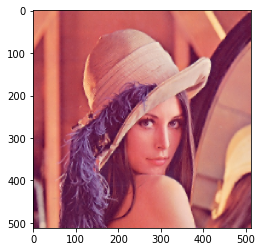

Iter: 100
RMSE: nan

Iter: 200
RMSE: nan

Iter: 300
RMSE: nan

Iter: 400
RMSE: nan

Iter: 500
RMSE: nan

Iter: 600
RMSE: nan

Iter: 700
RMSE: nan

Iter: 800
RMSE: nan

Iter: 900
RMSE: nan

Iter: 1000
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan



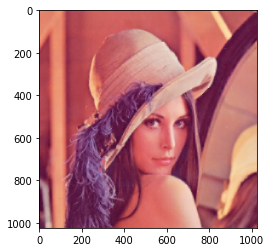

KeyboardInterrupt: 

In [15]:
dim1, dim2, dim3 = lena.shape

alpha = np.ones(3)/3
rho = 1
alpha = 0.1*rho
maxiter = 1000

enlarge = 2
for i in range(enlarge):
    lena_in = np.zeros((2*dim1*(i+1), 2* dim2*(i+1), 3)).astype(int)
    for m in range(dim1):
        for n in range(dim2):
            lena_in[2*m*(i+1), 2*n*(i+1)] = lena[m, n]
    dense_tensor = lena_in.copy()
    sparse_tensor = lena_in.copy()
    tensor_hat = GLTC(dense_tensor, sparse_tensor, alpha, rho, maxiter)
    lena_rec = np.round(tensor_hat).astype(int)
    lena_rec[np.where(lena_rec > 255)] = 255
    lena_rec[np.where(lena_rec < 0)] = 0
    plt.imshow(lena_rec)
    plt.axis('off')

    plt.show()

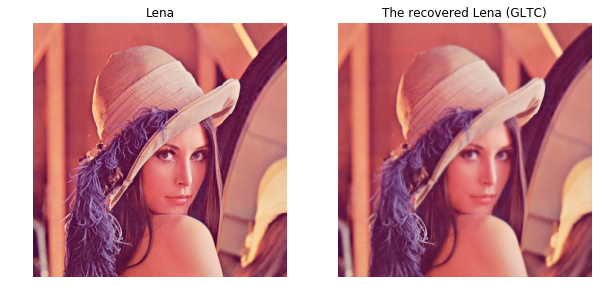

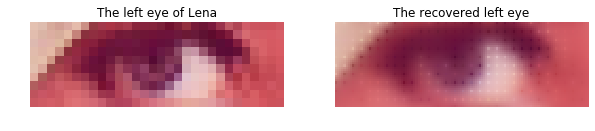

In [24]:
plt.subplots(1, 2, figsize=(10,15))

dim1, dim2, dim3 = lena.shape
a = int(dim1/2)
b = int(dim1/2) + 10
c = int(dim2/2) - 10
d = int(dim2/2) + 20

plt.subplot(1, 2, 1)
plt.imshow(lena)
plt.title('Lena')
plt.axis('off')

plt.subplot(1, 2, 2)
lena_rec = np.round(tensor_hat).astype(int)
lena_rec[np.where(lena_rec > 255)] = 255
lena_rec[np.where(lena_rec < 0)] = 0
plt.imshow(lena_rec)
plt.title('The recovered Lena (GLTC)')
plt.axis('off')

plt.show()

plt.subplots(1, 2, figsize=(10,15))

plt.subplot(1, 2, 1)
plt.imshow(lena[a:b, c:d, :])
plt.title('The left eye of Lena')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lena_rec[4*a:4*b, 4*c:4*d, :])
plt.title('The recovered left eye')
plt.axis('off')

plt.show()